**Mystem**




In [1]:
import pymystem3

In [2]:
from pymystem3 import Mystem

In [3]:
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [103]:
with open('Oxxxymiron.txt') as f:
    mystem_list = []
    text = f.read()
    analysis = m.analyze(text)
    for word in analysis:
        if 'analysis' in word and word['analysis'] != []:
            gram = word['analysis'][0]['gr']
            pos = gram.split('=')[0].split(',')[0]
            if pos == 'V':
                if 'прич,полн' in gram:
                    pos = 'PRTF'
                elif 'прич,кр' in gram:
                    pos = 'PRTS'
                elif 'деепр' in gram:
                    pos = 'GRND'
                elif 'инф' in gram:
                    pos = 'INFN'
            if pos == 'A':
                if 'полн' in gram:
                    pos = 'ADJF'
                elif 'кр' in gram:
                    pos = 'ADJS'
                elif 'срав' in gram:
                    pos = 'COMP'
            form = word['text']
            mystem_list.append([form.lower().replace('ё', 'е'), pos])

In [104]:
print(mystem_list[:10])

[['там', 'ADVPRO'], ['где', 'ADVPRO'], ['нас', 'SPRO'], ['нет', 'PART'], ['горит', 'V'], ['невиданный', 'ADJF'], ['рассвет', 'S'], ['где', 'ADVPRO'], ['нас', 'SPRO'], ['нет', 'PART']]


**Pymorphy**

In [ ]:
!pip install pymorphy2

In [6]:
import pymorphy2

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

In [130]:
import string
punctuation = string.punctuation

In [8]:
morph = pymorphy2.MorphAnalyzer(lang='ru')

In [161]:
with open('Oxxxymiron.txt') as f:
    text = f.read()
    words = [w for w in word_tokenize(text) if w not in punctuation]
    pymorphy_list = []
    for word in words:
        parsing = morph.parse(word)
        form = parsing[0].word
        tag = parsing[0].tag.POS
        if form != "''":
            pymorphy_list.append([form.replace('ё', 'е'), str(tag)])

In [159]:
print(pymorphy_list[:10])

[['там', 'ADVB'], ['где', 'ADVB'], ['нас', 'NPRO'], ['нет', 'PRED'], ['горит', 'VERB'], ['невиданный', 'ADJF'], ['рассвет', 'NOUN'], ['где', 'ADVB'], ['нас', 'NPRO'], ['нет', 'PRED']]


**Spacy**

In [ ]:
!pip install typing_extensions==4.7.1 --upgrade

In [ ]:
!python -m spacy download ru_core_news_sm

In [13]:
import spacy

In [14]:
s = spacy.load("ru_core_news_sm")

In [123]:
with open('Oxxxymiron.txt') as f:
    text = s(f.read())
    spacy_list = []
    for word in text:
        form = word.text
        tag = word.pos_
        if tag != 'PUNCT' and tag != 'SPACE' and form.isalpha():
            spacy_list.append([form.lower().replace('ё', 'е'), tag])

In [124]:
print(spacy_list[:10])

[['там', 'ADV'], ['где', 'ADV'], ['нас', 'PRON'], ['нет', 'VERB'], ['горит', 'VERB'], ['невиданный', 'ADJ'], ['рассвет', 'NOUN'], ['где', 'ADV'], ['нас', 'PRON'], ['нет', 'VERB']]


Для разметки я взяла теги из pymorphy. Во-первых, у этой библиотеки очень понятная документация, с которой удобно разбираться с тегами. Во-вторых, в тегах выделяются причастия и деепричастия, к тому же у причастий и прилагательных есть полная и краткая формы. А так как причастия - один из сложных моментов в разметке, очень хорошо бы их иметь.

На самом деле разметка в mystem тоже очень хорошая, но не на уровне простых тегов, а на более углублённом уровне, то есть причастия определяются, как глаголы, но дополнительно подписывается, что это форма - причастие.

*Посмотрим на теги, которые выделяют в тексте mystem и spacy*

In [89]:
mystem_pos = []
for word in mystem_list:
    if word[1] not in mystem_pos:
        mystem_pos.append(word[1])

In [90]:
print(mystem_pos)

['ADVPRO', 'SPRO', 'PART', 'V', 'ADJF', 'S', 'CONJ', 'ADV', 'PR', 'APRO', 'PRTF', 'INTJ', 'PRTS', 'NUM', 'COMP', 'INFN', 'ADJS', 'GRND', 'ANUM']


In [91]:
spacy_pos = []
for word in spacy_list:
    if word[1] not in spacy_pos:
        spacy_pos.append(word[1])

In [92]:
print(spacy_pos)

['ADV', 'PRON', 'VERB', 'ADJ', 'NOUN', 'CCONJ', 'SCONJ', 'ADP', 'PROPN', 'DET', 'PART', 'NUM', 'INTJ', 'AUX', 'X']


Словари, с помощью которых мы сопоставим теги библиотек. При этом для mystem я частично сделала сопоставление ещё раньше - на этапе составления списка слово-тег (чтобы не тащить все грамматические признаки).
В русском spacy не оказалось различий между .pos_ и .tag_

In [72]:
mystem_dict = {'ADVPRO':'ADVB', 'SPRO':'NPRO', 'PART':'PRCL',
               'V':'VERB', 'S':'NOUN', 'ADV':'ADVB', 'PR':'PREP',
               'APRO':'ADJF', 'NUM':'NUMR', 'ANUM':'ADJF',}

spacy_dict = {'ADJ':'ADJF', 'ADP':'PREP', 'ADV':'ADVB',
              'AUX':'VERB', 'CCONJ':'CONJ', 'DET':'ADJF',
              'NUM':'NUMR', 'PART':'PRCL', 'PRON':'NPRO',
              'PROPN':'NOUN', 'SCONJ':'CONJ'}

In [93]:
def one_pos_func(pos_list, pos_dict):
    new_pos_list = []
    for word in pos_list:
        tag = word[1]
        if tag in pos_dict:
            new_pos_list.append([word[0], pos_dict[tag]])
        else:
            new_pos_list.append(word)
    return new_pos_list

In [125]:
new_mystem_list = one_pos_func(mystem_list, mystem_dict)
new_spacy_list = one_pos_func(spacy_list, spacy_dict)

Читаем файл с размеченными словами. Среди них есть омонимы, слова с дефисом, которые должны разделяться или нет, абсценная лексика и несуществующие (вроде) слова (горгород), а ещё несколько не очень частотных в языке слов.
Тексты выбирались как раз по принципу интересности с точки зрения лексики (по-моему, всякие современные стихотворения или тексты реперов вполне подходят для этого задания).
Но хочется отметить проблему: не во всех песнях были знаки препинания, поэтому те, в которых они отсутствовали, я не взяла (а вдруг они помогают для контекстных морфопарсеров), а хотелось бы.

In [41]:
import pandas as pd

In [144]:
word_df = pd.read_excel('Oxxxymiron.xlsx', index_col='word')

In [219]:
word_df[:5]

,tag,before,after
word,,,
дали,NOUN,вижу,иноземные
марш,INTJ,коллективом,в
дважды-два,"ADVB, NUMR",класс,раз
баш,NOUN,раз,на
че,CONJ,баш,зассал


In [ ]:
word_dict = word_df.to_dict('index')
word_dict

In [227]:
def pos_accuracy(pos_list, word_dict):
    true_ans = 0
    false_ans = 0
    used_list = []
    for i in range(1, len(pos_list) - 1):
        word = pos_list[i][0]
        if word in word_dict and word not in used_list:
            if pos_list[i - 1][0] == word_dict[word]['before'] and pos_list[i + 1][0] == word_dict[word]['after']:
                if pos_list[i][1] == word_dict[word]['tag']:
                    true_ans += 1
                else:
                    false_ans += 1
                    #print(pos_list[i], word_dict[word])  # для вывода ошибок
                used_list.append(word)
        elif word == 'дважды':
            if pos_list[i + 1][0] == 'два':
                if pos_list[i][1] == 'ADVB' and pos_list[i + 1][1] == 'NUMR':
                    true_ans += 1
                else:
                    false_ans += 1
                    #print(pos_list[i])  # для вывода ошибок
        elif word == 'торгаш':
            if pos_list[i + 1][0] == 'коробейник':
                if pos_list[i][1] == 'NOUN' and pos_list[i + 1][1] == 'NOUN':
                    true_ans += 1
                else:
                    false_ans += 1
                    #print(pos_list[i])  # для вывода ошибок
        elif word == 'вице':
            false_ans += 1
            #print(pos_list[i])  # для вывода ошибок
    return true_ans / (true_ans + false_ans), true_ans, false_ans

In [228]:
print('Mystem:', pos_accuracy(new_mystem_list, word_dict))
print('Pymorphy:', pos_accuracy(pymorphy_list, word_dict))
print('Spacy:', pos_accuracy(new_spacy_list, word_dict))

Mystem: (0.8157894736842105, 31, 7)
Pymorphy: (0.8421052631578947, 32, 6)
Spacy: (0.6842105263157895, 26, 12)


Слова с дефисами парсились по-разному, а так как их не так много, я сделала костыли для их рассмотрения в функции. (Всякими разными принтами я проверила, что функция считает все верно/неверно определённые теги)

**Шаблоны**
1. Очень + ADVB/ADJF/VERB
Часто встречаются сочетания типа очень вкусно/вкусная/понравилось. Такие сочетания могут помочь определить положительные отзывы. Но при этом, если попадётся что-то из отрицательного отзыва - будет скорее 'очень медленно'.
2. Не + ADVB
Не часто встречается и в положительных отзывах, но с наречиями обычно употребляется в негативных отзывах, например, 'не вкусно', 'не аккуратно'
3. Быстро + VERB / VERB + быстро
Так как отзывы о пиццериях - в положительных отзывах часто обращают внимание на скорость приготовления, доставки и тп

Хоть по результатам pymorphy и оказался немного лучше, но мне больше нравится работа pymystem, так как он учитывает контекст и лучше работает со словами с дефисами.

In [172]:
import requests
import bs4
from bs4 import BeautifulSoup
import time
from datetime import datetime
import random

In [173]:
session = requests.session()

In [170]:
def feedbacks_loading(link):
    positive_list = []
    negative_list = []
    response = session.get(link)
    page = response.text
    soup = BeautifulSoup(page, 'html.parser')
    ratings = soup.find_all('span', {'class': 'com-star'})
    feedbacks_body = soup.find_all('div', {'class': 'text', 'itemprop': 'description'})
    for i in range(len(ratings)):
        stroka = ''
        rating = str(ratings[i])
        rate = int(rating[rating.find('meta') + 14])
        if rate > 4:
            positive_list.append(feedbacks_body[i].text)
        elif rate <= 3:
            negative_list.append(feedbacks_body[i].text)
    return positive_list, negative_list

In [174]:
pos_list, neg_list = feedbacks_loading('https://www.kaluga-poisk.ru/catalog/objects/peppers-pizza-peppers-pitstsa-y/reviews#cm-227550')

In [175]:
positive_set = set()
negative_set = set()

Функция ищет два идущих подряд слова (не пунктуация или пробелы) и проверяет, соответствует ли эта комбинация заданному чанку (лемма+тег или тег+лемма).

In [207]:
def chunker(first_word, second_word, analysis):
    res_list = []
    for i in range(len(analysis) - 1):
        word = analysis[i]
        if 'analysis' in word and word['analysis'] != []:
            t = 1
            while i + t < len(analysis):
                if 'analysis' in analysis[i + t] and analysis[i + t]['analysis'] != []:
                    next_word = analysis[i + t]
                    break
                t += 1
            if i + t >= len(analysis):
                break
            lex_1 = word['analysis'][0]['lex']
            gram_1 = word['analysis'][0]['gr']
            pos_1 = gram_1.split('=')[0].split(',')[0]
            lex_2 = next_word['analysis'][0]['lex']
            gram_2 = next_word['analysis'][0]['gr']
            pos_2 = gram_2.split('=')[0].split(',')[0]
            if first_word[0] == 'lemma':
                if lex_1 == first_word[1] and pos_2 in second_word[1]:
                    res_list.append(lex_1 + " " + lex_2)
            else:
                if pos_1 in first_word[1] and lex_2 == second_word[1]:
                    res_list.append(lex_1 + " " + lex_2)
    return res_list

In [186]:
chunks = [[['lemma', 'очень'], ['tag', ['ADV', 'V', 'A']]],
 [['lemma', 'не'], ['tag', ['ADV']]], [['lemma', 'быстро'], ['tag', ['V']]],
  [['tag', ['V']], ['lemma', 'быстро']]]

Отдельно составим сеты лемм

In [181]:
for text in neg_list:
    lemmas = m.lemmatize(text)
    text_set = set(lemmas)
    negative_set = negative_set | text_set

In [182]:
k = 0
for text in pos_list[::3]:
    k += 1
    lemmas = m.lemmatize(text)
    text_set = set(lemmas)
    positive_set = positive_set | text_set
    if k == 30:
        break

А потом добавим к ним биграммы

In [208]:
for text in neg_list:
    analysis = m.analyze(text)
    for chunk in chunks:
        lst = chunker(chunk[0], chunk[1], analysis)
        chunks_set = set(lst)
        negative_set = negative_set | chunks_set

In [209]:
k = 0
for text in pos_list[::3]:
    k += 1
    analysis = m.analyze(text)
    for chunk in chunks:
        lst = chunker(chunk[0], chunk[1], analysis)
        chunks_set = set(lst)
        positive_set = positive_set | chunks_set
    if k == 30:
        break

In [210]:
only_positive = positive_set - negative_set
only_negative = negative_set - positive_set

In [212]:
test_positive, test_negative = feedbacks_loading('https://www.kaluga-poisk.ru/catalog/objects/paprika-kaluga/reviews#cm-20978')

In [213]:
def check_tone(text, positive_set, negative_set, chunks):
    prediction = 0
    probability = [0, 0]
    lemmas = m.lemmatize(text)
    text_set = set(lemmas)
    analysis = m.analyze(text)
    for chunk in chunks:
        lst = chunker(chunk[0], chunk[1], analysis)
        chunks_set = set(lst)
        text_set = text_set | chunks_set
    positive_len = len(text_set & positive_set)
    negative_len = len(text_set & negative_set)
    if negative_len > positive_len:
        prediction = -1
    else:
        prediction = 1
    if positive_len + negative_len != 0:
        probability = [positive_len / (positive_len + negative_len), negative_len / (positive_len + negative_len)]
    return prediction, probability

Я помню замечание про неудобность вывода вероятностей, но мне так как-то нагляднее...

In [214]:
right_answers = 0
all_answers = 0
print('positive')
for text in test_positive:
    pred, prob = check_tone(text, only_positive, only_negative, chunks)
    print(prob)
    if pred == 1:
        right_answers += 1
    all_answers += 1
print('negative')
for text in test_negative:
    pred, prob = check_tone(text, only_positive, only_negative, chunks)
    print(prob)
    if pred == -1:
        right_answers += 1
    all_answers += 1
print('accuracy_score =', right_answers / all_answers)

positive
[0.6666666666666666, 0.3333333333333333]
[0.42857142857142855, 0.5714285714285714]
[0.5, 0.5]
[0.7142857142857143, 0.2857142857142857]
[0.625, 0.375]
[0.16666666666666666, 0.8333333333333334]
[0.3333333333333333, 0.6666666666666666]
[0.3111111111111111, 0.6888888888888889]
[0.3076923076923077, 0.6923076923076923]
negative
[0.27586206896551724, 0.7241379310344828]
[0.0, 1.0]
[0.2962962962962963, 0.7037037037037037]
[0.4444444444444444, 0.5555555555555556]
[0.13636363636363635, 0.8636363636363636]
[0.18181818181818182, 0.8181818181818182]
[0.17857142857142858, 0.8214285714285714]
[0.2222222222222222, 0.7777777777777778]
accuracy_score = 0.7058823529411765


Я использовала не лучший вариант из прошлой домашки, но по сравнению с accuracy_score = 0.64, заметно улучшение.

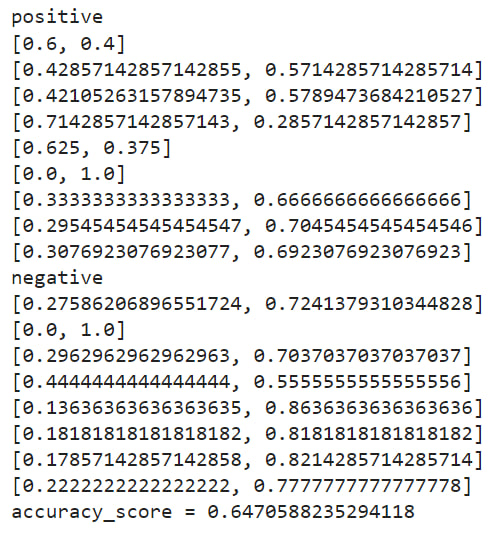

In [215]:
coef = len(only_positive) / len(only_negative)

In [216]:
def new_check_tone(text, positive_set, negative_set, coef):
    prediction = 0
    probability = [0, 0]
    lemmas = m.lemmatize(text)
    text_set = set(lemmas)
    for chunk in chunks:
        lst = chunker(chunk[0], chunk[1], analysis)
        chunks_set = set(lst)
        text_set = text_set | chunks_set
    positive_len = len(text_set & positive_set)
    negative_len = len(text_set & negative_set) * coef
    if negative_len > positive_len:
        prediction = -1
    else:
        prediction = 1
    if positive_len + negative_len != 0:
        probability = [positive_len / (positive_len + negative_len), negative_len / (positive_len + negative_len)]
    return prediction, probability

In [217]:
right_answers = 0
all_answers = 0
print('positive')
for text in test_positive:
    pred, prob = new_check_tone(text, only_positive, only_negative, coef)
    print(prob)
    if pred == 1:
        right_answers += 1
    all_answers += 1
print('negative')
for text in test_negative:
    pred, prob = new_check_tone(text, only_positive, only_negative, coef)
    print(prob)
    if pred == -1:
        right_answers += 1
    all_answers += 1
print('accuracy_score =', right_answers / all_answers)

positive
[0.8208955223880596, 0.1791044776119403]
[0.6962025316455697, 0.3037974683544304]
[0.6521739130434783, 0.34782608695652173]
[0.873015873015873, 0.12698412698412698]
[0.8208955223880597, 0.17910447761194032]
[0.3142857142857143, 0.6857142857142857]
[0.632183908045977, 0.367816091954023]
[0.5085865257595773, 0.4914134742404227]
[0.5339805825242718, 0.4660194174757281]
negative
[0.4954954954954955, 0.5045045045045046]
[0.3142857142857143, 0.6857142857142857]
[0.5205047318611988, 0.47949526813880133]
[0.6962025316455697, 0.3037974683544304]
[0.3254437869822485, 0.6745562130177515]
[0.43307086614173224, 0.5669291338582677]
[0.3741496598639456, 0.6258503401360545]
[0.4241645244215938, 0.5758354755784061]
accuracy_score = 0.8235294117647058


А вот сделать лучше того, что уже было улучшено - не получается... Хотя, если посмотреть на соотношение 'вероятностей', модель стала более уверенна на части отзывов.
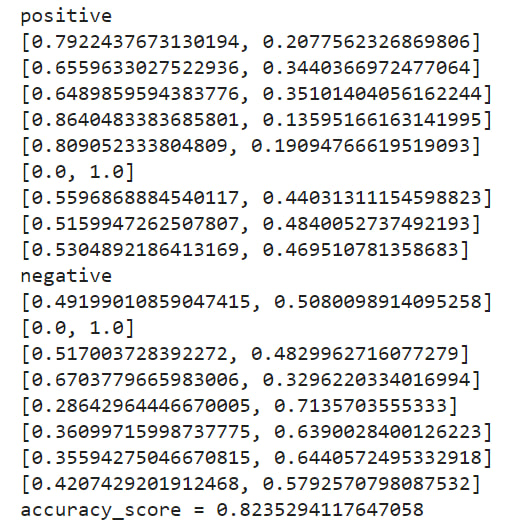